### Train a ALM in Google Colab!

### Clone the repository if you don't have it already

In [5]:
import os

if not os.path.isdir('nanoALM'):
    !git clone https://github.com/LWL220184016/nanoVLM_From_Huggingface.git
%cd nanoVLM_From_Huggingface/
!ls

fatal: destination path 'nanoVLM_From_Huggingface' already exists and is not an empty directory.
/content/nanoVLM_From_Huggingface
assets			debug_func.py				  nanoALM.ipynb
benchmark-inference.py	debug_tokenizer_dataset_compatibility.py  README.md
benchmark_suite.py	generate.py				  train.py
checkpoints		measure_vram.py
data			models


### Imports and Setup

In [ ]:
# Let's authentificate with the Hugging Face Hub so you can push your model
# from huggingface_hub import notebook_login
# notebook_login()
# !huggingface-cli login


In [7]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install tqdm
!pip -q install huggingface_hub
!pip -q install librosa
!pip install --upgrade datasets
!pip install --upgrade transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [8]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoALM"
# hf_model_name = "YOUR_HF_USER_NAME/nanoALM"

In [9]:
# nanoALM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import AudioQACollator, SAVEECollator
from data.datasets import SAVEEDataset, AudioQADataset
from data.processors import get_audio_processor
from data.processors import get_tokenizer
from models.audio_language_model import AudioLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.autograd.set_detect_anomaly(True)

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
trained_model = None

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [10]:
def get_dataloaders(train_cfg, alm_cfg):
    # Create datasets
    audio_processor = get_audio_processor(alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # text = "splitting datasets, disable in get_dataloaders function"
    # print(f"\n\033[38;5;05m{text}05m\033[0m")
    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(
        path = train_cfg.train_dataset_path,
        name = dataset_name,
    )
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)

    test_ds = load_dataset(train_cfg.test_dataset_path)
    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = AudioQADataset(train_ds.select(range(train_size)), tokenizer, audio_processor)
    val_dataset = AudioQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, audio_processor)
    test_dataset = SAVEEDataset(test_ds, tokenizer, audio_processor)

    # Create collators
    aqa_collator = AudioQACollator(tokenizer, alm_cfg.lm_max_length)
    savee_collator = SAVEECollator(tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.savee_batch_size,
        shuffle=False,
        collate_fn=savee_collator,
        pin_memory=True,
        )

    return train_loader, val_loader, test_loader

### Prepare the testing function

In [11]:
def test_savee(model, tokenizer, test_loader, device):
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            audio = batch['audios'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, audio, attention_mask)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)
    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    return accuracy

### Add debug

In [12]:
# 在训练开始前添加这个检查函数
def debug_model_dimensions(model, input_ids, audio):
    """调试模型各层的维度"""
    print("=== Model Dimension Debug ===")

    # 检查音频编码器
    audio_features = model.audio_encoder.forward(audio, output_hidden_states=True)
    print(f"Audio features shape: {audio_features.shape}")

    # 检查模态投影器
    audio_embeds = model.MP(audio_features)
    print(f"Audio embeds shape: {audio_embeds.shape}")

    # 检查文本嵌入
    text_embeds = model.decoder.token_embedding(input_ids)
    print(f"Text embeds shape: {text_embeds.shape}")

    # 检查拼接后的嵌入
    inputs_embeds = torch.cat([audio_embeds, text_embeds], dim=1)
    print(f"Combined embeds shape: {inputs_embeds.shape}")

    # 检查语言模型输出
    logits = model.decoder(inputs_embeds)
    print(f"Logits shape: {logits.shape}")
    print(f"Vocab size (last dim): {logits.shape[-1]}")

    # 检查语言模型配置
    print(f"LM vocab size config: {model.cfg.lm_vocab_size}")
    print(f"Decoder vocab size: {getattr(model.decoder, 'vocab_size', 'Not found')}")

    return logits.shape[-1]

# 在训练循环开始前调用
# vocab_size = debug_model_dimensions(model, input_ids, audios)

In [13]:
def debug_training_step(model, input_ids, audios, attention_mask, labels):
    """调试训练步骤"""
    # 添加这些调试行：
    print(f"Batch debug - input_ids shape: {input_ids.shape}, max: {input_ids.max().item()}")
    print(f"Batch debug - labels shape: {labels.shape}, max: {labels.max().item()}")
    print(f"Batch debug - Model vocab config: {model.cfg.lm_vocab_size}")

    # 检查decoder的实际vocab_size
    if hasattr(model.decoder, 'head') and hasattr(model.decoder.head, 'out_features'):
        print(f"Decoder head in_features: {model.decoder.head.in_features}")
        print(f"Decoder head out_features: {model.decoder.head.out_features}")

### Prepare the training loop

#### Supervised learning and Generative Training 監督學習生成式訓練

In [14]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, alm_cfg):
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # Initialize model
    if train_cfg.resume_from_alm_checkpoint:
        model = AudioLanguageModel.from_pretrained(alm_cfg.alm_checkpoint_path)
    else:
        model = AudioLanguageModel(alm_cfg)

    print(f"nanoALM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.audio_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # debug_model_dimensions(model, input_ids, audios)  # Debug model dimensions with dummy data
            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, len(train_loader) * train_cfg.epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item()
            # 修改音頻token計算：根據實際的音頻處理方式
            audio_tokens = audios.shape[0] * alm_cfg.mp_target_length  # 使用配置的目標長度
            num_tokens += audio_tokens
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 5 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        audios = batch["audio"].to(device)
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                            _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_savee(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
        model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
    try:
        model.push_to_hub(hf_model_name)
    except Exception as e:
        print(f"Error pushing model to hub: {e}")

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

    # With this code you can test the accuracy of the model on the SAVEE dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing SAVEE Accuracy:")
    # accuracy = test_savee(model, tokenizer, test_loader, device)
    # print(f"SAVEE Accuracy: {accuracy:.4f}")

#### Three-stage training (contrast training, generative training, instruction fine-tuning) 三段式訓練(對比訓練, 生成式訓練, 指令微調)

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

# 改進對比學習訓練
def contrastive_loss(audio_embeds, text_embeds, temperature=0.07, margin=0.2):
    """修復的對比學習損失"""
    batch_size = audio_embeds.shape[0]
    
    # 更強的池化策略 - 使用注意力池化而不是平均池化
    # 音頻池化
    audio_attention = torch.softmax(
        torch.mean(audio_embeds, dim=-1), dim=-1
    ).unsqueeze(-1)
    audio_pooled = torch.sum(audio_embeds * audio_attention, dim=1)
    
    # 文本池化
    text_attention = torch.softmax(
        torch.mean(text_embeds, dim=-1), dim=-1
    ).unsqueeze(-1)
    text_pooled = torch.sum(text_embeds * text_attention, dim=1)
    
    # 強制歸一化
    audio_pooled = F.normalize(audio_pooled, p=2, dim=-1)
    text_pooled = F.normalize(text_pooled, p=2, dim=-1)
    
    # 計算相似度矩陣
    logits = torch.matmul(audio_pooled, text_pooled.T) / temperature
    
    # 創建標籤
    labels = torch.arange(batch_size).to(logits.device)
    
    # 添加困難負樣本挖掘
    with torch.no_grad():
        # 找到最困難的負樣本（相似度最高的非匹配對）
        mask = torch.eye(batch_size).bool().to(logits.device)
        neg_logits = logits.masked_fill(mask, float('-inf'))
        hard_negatives = torch.max(neg_logits, dim=1)[0]
        
        # 如果困難負樣本太接近正樣本，增加溫度
        pos_logits = torch.diag(logits)
        if (hard_negatives - pos_logits).mean() < margin:
            temperature = min(temperature * 1.1, 0.2)
    
    # 重新計算 logits
    logits = torch.matmul(audio_pooled, text_pooled.T) / temperature
    
    # 雙向對比損失
    loss_a2t = F.cross_entropy(logits, labels, label_smoothing=0.1)
    loss_t2a = F.cross_entropy(logits.T, labels, label_smoothing=0.1)
    
    # 添加正則化項確保特徵不會塌陷
    audio_var = torch.var(audio_pooled, dim=0).mean()
    text_var = torch.var(text_pooled, dim=0).mean()
    variance_loss = -torch.log(audio_var + 1e-8) - torch.log(text_var + 1e-8)
    
    total_loss = (loss_a2t + loss_t2a) / 2 + 0.01 * variance_loss
    
    return total_loss, {
        'a2t_loss': loss_a2t.item(),
        't2a_loss': loss_t2a.item(), 
        'variance_loss': variance_loss.item(),
        'temperature': temperature,
        'pos_sim': pos_logits.mean().item(),
        'neg_sim': hard_negatives.mean().item()
    }

def train_step1_alignment(train_cfg, alm_cfg):
    """改進的第一階段訓練"""
    print("=== Improved Stage 1: Modality Projector Alignment ===")
    
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)
    
    model = AudioLanguageModel(alm_cfg)
    
    # 只訓練 MP，凍結其他部分
    for param in model.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = False
    for param in model.MP.parameters():
        param.requires_grad = True
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 使用更激進的學習率和優化器設置
    optimizer = optim.AdamW(
        model.MP.parameters(), 
        lr=train_cfg.lr_mp * 2,  # 更高的學習率
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    # 使用余弦退火學習率
    total_steps = len(train_loader) * train_cfg.stage1_epochs
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=total_steps // 4,  # 4 次重啟
        T_mult=2,
        eta_min=train_cfg.lr_mp * 0.01
    )
    
    batch_losses = []
    best_alignment = 0
    patience = 0
    max_patience = 10
    
    for epoch in range(train_cfg.stage1_epochs):
        model.train()
        total_train_loss = 0
        epoch_metrics = {
            'a2t_loss': 0, 't2a_loss': 0, 'variance_loss': 0,
            'pos_sim': 0, 'neg_sim': 0
        }
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Stage1 Epoch {epoch+1}")):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            
            # 定期調試
            if batch_idx == 0 and epoch % 5 == 0:
                debug_contrastive_learning(model, batch, device)
            
            optimizer.zero_grad()
            
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 音頻編碼
                input_features = audios.to(device)
                with torch.no_grad():
                    encoder_outputs = model.audio_encoder.encoder(input_features, output_hidden_states=True)
                
                audio_features = encoder_outputs.last_hidden_state
                audio_embeds = model.MP(audio_features)
                
                # 文本編碼
                with torch.no_grad():
                    text_embeds = model.decoder.token_embedding(input_ids[:, :-1])
                
                # 改進的對比學習損失
                loss, metrics = contrastive_loss(audio_embeds, text_embeds)
            
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.MP.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            # 累積指標
            total_train_loss += loss.item()
            for key in epoch_metrics:
                epoch_metrics[key] += metrics[key]
            
            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)
        
        # 計算平均指標
        avg_train_loss = total_train_loss / len(train_loader)
        for key in epoch_metrics:
            epoch_metrics[key] /= len(train_loader)
        
        print(f"Stage1 Epoch {epoch+1}: Loss {avg_train_loss:.4f}")
        print(f"  A2T: {epoch_metrics['a2t_loss']:.4f}, T2A: {epoch_metrics['t2a_loss']:.4f}")
        print(f"  Pos Sim: {epoch_metrics['pos_sim']:.4f}, Neg Sim: {epoch_metrics['neg_sim']:.4f}")
        print(f"  Variance Loss: {epoch_metrics['variance_loss']:.4f}")
        
        # 驗證對齊效果
        if epoch % 2 == 0:  # 每兩個epoch驗證一次
            model.eval()
            total_alignment_score = 0
            with torch.no_grad():
                for batch in val_loader:
                    audios = batch["audio"].to(device)
                    input_ids = batch["input_ids"].to(device)
                    alignment_score = model.validate_audio_text_alignment(input_ids, audios)
                    total_alignment_score += alignment_score
            
            avg_alignment = total_alignment_score / len(val_loader)
            print(f"  Average alignment score: {avg_alignment:.4f}")
            
            # 早停和模型保存
            if avg_alignment > best_alignment:
                best_alignment = avg_alignment
                patience = 0
                model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage1_best")
                print(f"  New best alignment: {best_alignment:.4f}")
            else:
                patience += 1
                print(f"  No improvement, patience: {patience}/{max_patience}")
                
                # 如果對齊分數太低，調整學習率
                if avg_alignment < 0.15:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= 1.5
                    print(f"  Increased learning rate to: {optimizer.param_groups[0]['lr']:.2e}")
            
            # 早停
            if patience >= max_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
            model.train()
    
    print(f"Stage 1 completed! Best alignment: {best_alignment:.4f}")
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage1_final")

    # 绘制损失曲线
    plt.plot(batch_losses, label='Contrastive Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Stage 1: Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

def train_step2_pretraining(train_cfg, alm_cfg, stage1_model=None):
    """第二步：语言模型预训练"""
    print("=== Stage 2: Language Model Pretraining ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第一阶段模型或从头开始
    if stage1_model is not None:
        model = stage1_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage1_final")
            print("Loaded Stage 1 model")
        except:
            model = AudioLanguageModel(alm_cfg)
            print("Starting Stage 2 from scratch")

    # 冻结音频编码器，解冻语言模型和模态投影器
    for param in model.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    for param in model.MP.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Stage 2: Training {trainable_params:,} parameters")

    # 不同学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.1},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones}
    ]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_loss = float('inf')
    global_step = 0

    for epoch in range(train_cfg.stage2_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage2 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 使用因果语言建模损失
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            # 动态学习率调整
            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp * 0.1, len(train_loader) * train_cfg.stage2_epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.stage2_epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_best")

    # 保存第二阶段模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_final")
    print("Stage 2 completed!")
    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

def train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model=None):
    """第三步：指令微调"""
    print("=== Stage 3: Instruction Tuning ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第二阶段模型
    if stage2_model is not None:
        model = stage2_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage2_final")
            print("Loaded Stage 2 model")
        except:
            print("No Stage 2 model found, using current model")
            model = AudioLanguageModel(alm_cfg)

    # 全部解冻，使用较小学习率
    for param in model.parameters():
        param.requires_grad = True

    print(f"Stage 3: Training all {sum(p.numel() for p in model.parameters()):,} parameters")

    # 更小的学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.01},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones * 0.1},
        {'params': model.audio_encoder.parameters(), 'lr': train_cfg.lr_backbones * 0.01}
    ]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    # 这里可以使用原来的训练循环，但数据应该是指令格式
    # 暂时使用相同的数据格式
    best_accuracy = 0
    global_step = 0

    for epoch in range(train_cfg.stage3_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage3 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss

            if global_step % 50 == 0:
                print(f"Stage3 Step: {global_step}, Instruction Loss: {batch_loss:.4f}")

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        # 评估性能
        if train_cfg.eval_in_epochs:
            accuracy = test_savee(model, tokenizer, test_loader, device)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage3_best")
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Loss: {avg_train_loss:.4f} | Accuracy: {accuracy:.4f}")
        else:
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Instruction Loss: {avg_train_loss:.4f}")

    # 保存最终模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/final_model")
    print("Stage 3 completed!")
    return model

def train_three_stages(train_cfg, alm_cfg):
    """完整的三阶段训练"""
    print("Starting Three-Stage Training Pipeline")

    # 第一阶段：模态投影器对齐
    stage1_model = train_step1_alignment(train_cfg, alm_cfg)

    # 第二阶段：语言模型预训练
    stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model)

    # 第三阶段：指令微调
    final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model)

    print("=== Training Pipeline Completed! ===")
    return stage1_model, stage2_model, final_model


# # 替换原来的训练调用
# alm_cfg = ALMConfig()
# train_cfg = TrainConfig()

# # 运行三阶段训练
# final_model = train_three_stages(train_cfg, alm_cfg)

### Lets run the training!

In [13]:
import os
from models.config import ALMConfig, TrainConfig

# 要創建的目錄路徑
dir_name = ALMConfig.alm_checkpoint_path

try:
    os.mkdir(dir_name)
    print(f"Directory '{dir_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{dir_name}' already exists.")
except FileNotFoundError:
    print(f"Parent directory does not exist for '{dir_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory 'checkpoints' created successfully.


=== Stage 1: Modality Projector Alignment (with Pretraining) ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/489 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/151 [00:00<?, ?it/s]

train-00000-of-00151.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

train-00001-of-00151.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

train-00002-of-00151.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00003-of-00151.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

train-00004-of-00151.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

train-00005-of-00151.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00006-of-00151.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00007-of-00151.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

train-00008-of-00151.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00009-of-00151.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

train-00010-of-00151.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

train-00011-of-00151.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00012-of-00151.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00013-of-00151.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00014-of-00151.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

train-00015-of-00151.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

train-00016-of-00151.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00017-of-00151.parquet:   0%|          | 0.00/528M [00:00<?, ?B/s]

train-00018-of-00151.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

train-00019-of-00151.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00020-of-00151.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00021-of-00151.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00022-of-00151.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00023-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00024-of-00151.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00025-of-00151.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00026-of-00151.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00027-of-00151.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00028-of-00151.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

train-00029-of-00151.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

train-00030-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00031-of-00151.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

train-00032-of-00151.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00033-of-00151.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

train-00034-of-00151.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

train-00035-of-00151.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

train-00036-of-00151.parquet:   0%|          | 0.00/514M [00:00<?, ?B/s]

train-00037-of-00151.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00038-of-00151.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

train-00039-of-00151.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00040-of-00151.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

train-00041-of-00151.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

train-00042-of-00151.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00043-of-00151.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00044-of-00151.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00045-of-00151.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

train-00046-of-00151.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

train-00047-of-00151.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

train-00048-of-00151.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00049-of-00151.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

train-00050-of-00151.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00051-of-00151.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00052-of-00151.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00053-of-00151.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00054-of-00151.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

train-00055-of-00151.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

train-00056-of-00151.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

train-00057-of-00151.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

train-00058-of-00151.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00059-of-00151.parquet:   0%|          | 0.00/411M [00:00<?, ?B/s]

train-00060-of-00151.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

train-00061-of-00151.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00062-of-00151.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00063-of-00151.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00064-of-00151.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00065-of-00151.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

train-00066-of-00151.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00067-of-00151.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00068-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00069-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00070-of-00151.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

train-00071-of-00151.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00072-of-00151.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

train-00073-of-00151.parquet:   0%|          | 0.00/430M [00:00<?, ?B/s]

train-00074-of-00151.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

train-00075-of-00151.parquet:   0%|          | 0.00/430M [00:00<?, ?B/s]

train-00076-of-00151.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00077-of-00151.parquet:   0%|          | 0.00/414M [00:00<?, ?B/s]

train-00078-of-00151.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00079-of-00151.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

train-00080-of-00151.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00081-of-00151.parquet:   0%|          | 0.00/414M [00:00<?, ?B/s]

train-00082-of-00151.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00083-of-00151.parquet:   0%|          | 0.00/433M [00:00<?, ?B/s]

train-00084-of-00151.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

train-00085-of-00151.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

train-00086-of-00151.parquet:   0%|          | 0.00/430M [00:00<?, ?B/s]

train-00087-of-00151.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00088-of-00151.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00089-of-00151.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

train-00090-of-00151.parquet:   0%|          | 0.00/435M [00:00<?, ?B/s]

train-00091-of-00151.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

train-00092-of-00151.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

train-00093-of-00151.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00094-of-00151.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

train-00095-of-00151.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

train-00096-of-00151.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00097-of-00151.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00098-of-00151.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00099-of-00151.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00100-of-00151.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

train-00101-of-00151.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

train-00102-of-00151.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

train-00103-of-00151.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

train-00104-of-00151.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00105-of-00151.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00106-of-00151.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00107-of-00151.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00108-of-00151.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00109-of-00151.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00110-of-00151.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

train-00111-of-00151.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

train-00112-of-00151.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00113-of-00151.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00114-of-00151.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00115-of-00151.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00116-of-00151.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00117-of-00151.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00118-of-00151.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

train-00119-of-00151.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

train-00120-of-00151.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00121-of-00151.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00122-of-00151.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00123-of-00151.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

train-00124-of-00151.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00125-of-00151.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00126-of-00151.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00127-of-00151.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00128-of-00151.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00129-of-00151.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00130-of-00151.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

train-00131-of-00151.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00132-of-00151.parquet:   0%|          | 0.00/435M [00:00<?, ?B/s]

train-00133-of-00151.parquet:   0%|          | 0.00/422M [00:00<?, ?B/s]

train-00134-of-00151.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00135-of-00151.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

train-00136-of-00151.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

train-00137-of-00151.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00138-of-00151.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

train-00139-of-00151.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00140-of-00151.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00141-of-00151.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00142-of-00151.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00143-of-00151.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

train-00144-of-00151.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00145-of-00151.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00146-of-00151.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

train-00147-of-00151.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00148-of-00151.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

train-00149-of-00151.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00150-of-00151.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

validation-00000-of-00005.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

validation-00001-of-00005.parquet:   0%|          | 0.00/530M [00:00<?, ?B/s]

validation-00002-of-00005.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

validation-00003-of-00005.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

validation-00004-of-00005.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

test-00000-of-00008.parquet:   0%|          | 0.00/460M [00:00<?, ?B/s]

test-00001-of-00008.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

test-00002-of-00008.parquet:   0%|          | 0.00/564M [00:00<?, ?B/s]

test-00003-of-00008.parquet:   0%|          | 0.00/557M [00:00<?, ?B/s]

test-00004-of-00008.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

test-00005-of-00008.parquet:   0%|          | 0.00/593M [00:00<?, ?B/s]

test-00006-of-00008.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

test-00007-of-00008.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/257093 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/34898 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/133 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/622 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/480 [00:00<?, ? examples/s]

Loading from backbone weights


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

Successfully loaded HuggingFaceTB/SmolLM2-1.7B weights from safetensors. Model has 1,711,376,384 parameters.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


--- Stage 0.5: MP Pretraining with Reconstruction Loss ---


MP Pretrain Epoch 1: 100%|██████████| 68/68 [00:26<00:00,  2.57it/s]


MP Pretrain Epoch 1: Reconstruction Loss 0.7037


MP Pretrain Epoch 2: 100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


MP Pretrain Epoch 2: Reconstruction Loss 0.3365


MP Pretrain Epoch 3: 100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


MP Pretrain Epoch 3: Reconstruction Loss 0.2282


MP Pretrain Epoch 4: 100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


MP Pretrain Epoch 4: Reconstruction Loss 0.2046


MP Pretrain Epoch 5: 100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


MP Pretrain Epoch 5: Reconstruction Loss 0.1932


MP Pretrain Epoch 6: 100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


MP Pretrain Epoch 6: Reconstruction Loss 0.1860
MP Pretraining completed! Starting contrastive learning...


Stage1 Epoch 1:   3%|▎         | 2/68 [00:02<00:58,  1.14it/s]

Step 0: Loss 2.5120, LR 1.01e-07


Stage1 Epoch 1: 100%|██████████| 68/68 [00:13<00:00,  5.20it/s]


Stage1 Epoch 1: Contrastive Loss 2.4955


Stage1 Epoch 2:  50%|█████     | 34/68 [00:07<00:05,  6.05it/s]

Step 100: Loss 2.4829, LR 2.50e-06


Stage1 Epoch 2: 100%|██████████| 68/68 [00:12<00:00,  5.24it/s]


Stage1 Epoch 2: Contrastive Loss 2.4701


Stage1 Epoch 3:  97%|█████████▋| 66/68 [00:12<00:00,  6.27it/s]

Step 200: Loss 2.4129, LR 2.43e-06


Stage1 Epoch 3: 100%|██████████| 68/68 [00:13<00:00,  5.12it/s]


Stage1 Epoch 3: Contrastive Loss 2.4061


Stage1 Epoch 4: 100%|██████████| 68/68 [00:12<00:00,  5.30it/s]


Stage1 Epoch 4: Contrastive Loss 2.3416


Stage1 Epoch 5:  44%|████▍     | 30/68 [00:06<00:06,  6.23it/s]

Step 300: Loss 2.3374, LR 2.22e-06


Stage1 Epoch 5: 100%|██████████| 68/68 [00:12<00:00,  5.38it/s]


Stage1 Epoch 5: Contrastive Loss 2.3112


Stage1 Epoch 6:  91%|█████████ | 62/68 [00:11<00:01,  5.96it/s]

Step 400: Loss 2.3543, LR 1.90e-06


Stage1 Epoch 6: 100%|██████████| 68/68 [00:12<00:00,  5.30it/s]


Stage1 Epoch 6: Contrastive Loss 2.2901


Stage1 Epoch 7: 100%|██████████| 68/68 [00:12<00:00,  5.34it/s]


Stage1 Epoch 7: Contrastive Loss 2.2740


Stage1 Epoch 8:  38%|███▊      | 26/68 [00:05<00:06,  6.14it/s]

Step 500: Loss 2.2944, LR 1.50e-06


Stage1 Epoch 8: 100%|██████████| 68/68 [00:12<00:00,  5.33it/s]


Stage1 Epoch 8: Contrastive Loss 2.2610


Stage1 Epoch 9:  85%|████████▌ | 58/68 [00:11<00:01,  6.00it/s]

Step 600: Loss 2.1837, LR 1.08e-06


Stage1 Epoch 9: 100%|██████████| 68/68 [00:12<00:00,  5.23it/s]


Stage1 Epoch 9: Contrastive Loss 2.2531


Stage1 Epoch 10: 100%|██████████| 68/68 [00:13<00:00,  5.21it/s]


Stage1 Epoch 10: Contrastive Loss 2.2412


Stage1 Epoch 11:  32%|███▏      | 22/68 [00:05<00:07,  6.05it/s]

Step 700: Loss 2.2565, LR 6.70e-07


Stage1 Epoch 11: 100%|██████████| 68/68 [00:12<00:00,  5.34it/s]


Stage1 Epoch 11: Contrastive Loss 2.2260


Stage1 Epoch 12:  79%|███████▉  | 54/68 [00:10<00:02,  6.16it/s]

Step 800: Loss 2.1727, LR 3.32e-07


Stage1 Epoch 12: 100%|██████████| 68/68 [00:12<00:00,  5.32it/s]


Stage1 Epoch 12: Contrastive Loss 2.2301


Stage1 Epoch 13: 100%|██████████| 68/68 [00:12<00:00,  5.26it/s]


Stage1 Epoch 13: Contrastive Loss 2.2209


Stage1 Epoch 14:  26%|██▋       | 18/68 [00:04<00:08,  5.76it/s]

Step 900: Loss 2.2122, LR 1.01e-07


Stage1 Epoch 14: 100%|██████████| 68/68 [00:12<00:00,  5.29it/s]


Stage1 Epoch 14: Contrastive Loss 2.2206


Stage1 Epoch 15:  74%|███████▎  | 50/68 [00:09<00:03,  5.98it/s]

Step 1000: Loss 2.1820, LR 2.38e-09


Stage1 Epoch 15: 100%|██████████| 68/68 [00:12<00:00,  5.27it/s]


Stage1 Epoch 15: Contrastive Loss 2.2168
Stage 1 completed!


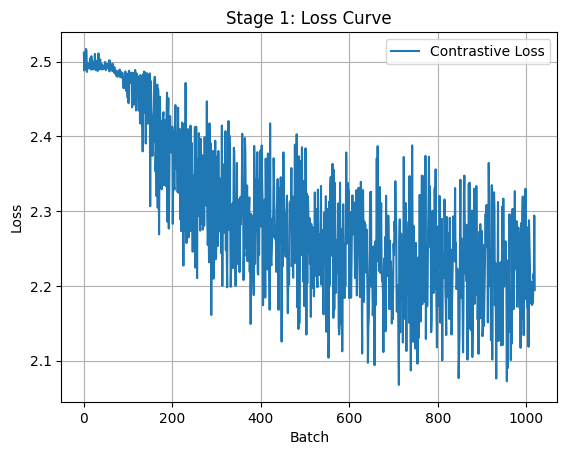

=== Stage 2: Language Model Pretraining ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240


Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/151 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/133 [00:00<?, ?it/s]

Stage 2: Training 1,882,306,048 parameters


Stage2 Epoch 12: 100%|██████████| 68/68 [01:23<00:00,  1.23s/it]


Stage 2 completed!


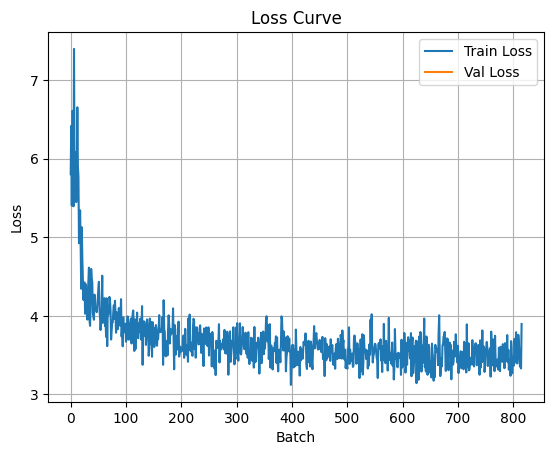

=== Stage 3: Instruction Tuning ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240


Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/151 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/133 [00:00<?, ?it/s]

Stage 3: Training all 2,124,040,192 parameters


Stage3 Epoch 1:   1%|▏         | 1/68 [00:03<03:54,  3.51s/it]

Stage3 Step: 0, Instruction Loss: 3.5728


Stage3 Epoch 1:  75%|███████▌  | 51/68 [01:03<00:20,  1.19s/it]

Stage3 Step: 50, Instruction Loss: 3.5984


Stage3 Epoch 1: 100%|██████████| 68/68 [01:24<00:00,  1.24s/it]


Stage3 Epoch 1/8 | Instruction Loss: 3.4934


Stage3 Epoch 2:  49%|████▊     | 33/68 [00:40<00:41,  1.19s/it]

Stage3 Step: 100, Instruction Loss: 3.4736


Stage3 Epoch 2: 100%|██████████| 68/68 [01:23<00:00,  1.22s/it]


Stage3 Epoch 2/8 | Instruction Loss: 3.4893


Stage3 Epoch 3:  22%|██▏       | 15/68 [00:19<01:03,  1.20s/it]

Stage3 Step: 150, Instruction Loss: 3.3472


Stage3 Epoch 3:  96%|█████████▌| 65/68 [01:20<00:03,  1.20s/it]

Stage3 Step: 200, Instruction Loss: 3.3188


Stage3 Epoch 3: 100%|██████████| 68/68 [01:23<00:00,  1.23s/it]


Stage3 Epoch 3/8 | Instruction Loss: 3.4833


Stage3 Epoch 4:  69%|██████▉   | 47/68 [00:58<00:25,  1.19s/it]

Stage3 Step: 250, Instruction Loss: 3.5276


Stage3 Epoch 4: 100%|██████████| 68/68 [01:24<00:00,  1.24s/it]


Stage3 Epoch 4/8 | Instruction Loss: 3.4786


Stage3 Epoch 5:  43%|████▎     | 29/68 [00:37<00:47,  1.21s/it]

Stage3 Step: 300, Instruction Loss: 3.5394


Stage3 Epoch 5: 100%|██████████| 68/68 [01:24<00:00,  1.25s/it]


Stage3 Epoch 5/8 | Instruction Loss: 3.4748


Stage3 Epoch 6:  16%|█▌        | 11/68 [00:14<01:09,  1.21s/it]

Stage3 Step: 350, Instruction Loss: 3.5059


Stage3 Epoch 6:  90%|████████▉ | 61/68 [01:15<00:08,  1.19s/it]

Stage3 Step: 400, Instruction Loss: 3.6389


Stage3 Epoch 6: 100%|██████████| 68/68 [01:23<00:00,  1.23s/it]


Stage3 Epoch 6/8 | Instruction Loss: 3.4693


Stage3 Epoch 7:  63%|██████▎   | 43/68 [00:53<00:29,  1.20s/it]

Stage3 Step: 450, Instruction Loss: 3.3794


Stage3 Epoch 7: 100%|██████████| 68/68 [01:23<00:00,  1.23s/it]


Stage3 Epoch 7/8 | Instruction Loss: 3.4668


Stage3 Epoch 8:  37%|███▋      | 25/68 [00:32<00:51,  1.20s/it]

Stage3 Step: 500, Instruction Loss: 3.6593


Stage3 Epoch 8: 100%|██████████| 68/68 [01:24<00:00,  1.24s/it]


Stage3 Epoch 8/8 | Instruction Loss: 3.4635
Stage 3 completed!


In [ ]:

alm_cfg = ALMConfig()
train_cfg = TrainConfig()

# trained_model = train(train_cfg, alm_cfg)
stage1_model = train_step1_alignment(train_cfg, alm_cfg)



stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model)
final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model)
# stage1_model, stage2_model, final_model = train_three_stages(train_cfg, alm_cfg)

stage1_model.save_pretrained("/content/")
stage2_model.save_pretrained("/content/")
final_model.save_pretrained("/content/")

In [15]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it

### Test

In [ ]:
!cp /content/drive/MyDrive/nanoALM/output_txt1.wav /content/output_txt1.wav
!cp /content/drive/MyDrive/nanoALM/output_txt2.wav /content/output_txt2.wav
!cp /content/drive/MyDrive/nanoALM/output_txt3.wav /content/output_txt3.wav

cp: cannot stat '/content/drive/MyDrive/nanoALM/output_txt1.wav': No such file or directory
cp: cannot stat '/content/drive/MyDrive/nanoALM/output_txt2.wav': No such file or directory
cp: cannot stat '/content/drive/MyDrive/nanoALM/output_txt3.wav': No such file or directory


In [16]:
!cp ../model.safetensors /content/drive/MyDrive/nanoALM/model.safetensors
!cp ../config.json /content/drive/MyDrive/nanoALM/config.json
!cp ./model.safetensors /content/drive/MyDrive/nanoALM
!cp ./config.json /content/drive/MyDrive/nanoALM

cp: cannot create regular file '/content/drive/MyDrive/nanoALM': No such file or directory
cp: cannot create regular file '/content/drive/MyDrive/nanoALM': No such file or directory
cp: cannot stat './model.safetensors': No such file or directory
cp: cannot stat './config.json': No such file or directory


In [16]:
# final_model.save_pretrained("/content/")
!python generate.py --checkpoint ../ --audio ../output_txt1.wav

2025-06-28 07:21:33.124459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751095293.145115   21209 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751095293.151440   21209 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Loading weights from: ../
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sam

In [17]:
!python generate.py --checkpoint ../ --audio ../output_txt2.wav

2025-06-28 07:22:37.175464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751095357.197105   21664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751095357.203762   21664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Loading weights from: ../
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sam

In [18]:
!python generate.py --checkpoint ../ --audio ../output_txt3.wav

2025-06-28 07:23:37.560159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751095417.581994   22094 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751095417.588806   22094 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Loading weights from: ../
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sam

In [21]:
!python generate.py --checkpoint ../ --audio ../output_txt3.wav

2025-06-28 07:31:43.640351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751095903.662180   25297 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751095903.668863   25297 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Loading weights from: ../
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sam